# Comparison of correlation coefficients
This notebook demonstrates why `scmorph` incorporates the Chatterjee correlation
coefficient. In princinple, this coefficient, called $\xi$ (xi), measures the
degree of dependence between two variables. The important difference with other
correlation coefficients is that it does not assume monotonicity of
relationships, i.e. period relationships can be found with $\xi$ but not e.g.
Spearman. Here we will see what those relationships can look like in the context
of morphological profiling.

In [1]:
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import scmorph as sm
import matplotlib.pyplot as plt

In [2]:
# load in data and subset to run faster
adata = sm.datasets.rohban2017_minimal()
sm.pp.drop_na(adata)
adata = sc.pp.subsample(adata, n_obs=1000, copy=True, random_state=2025)

In [3]:
# compute various correlation coefficients
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    sm.pp.feature_selection.corr_features(adata, method="pearson")
    sm.pp.feature_selection.corr_features(adata, method="spearman")
    sm.pp.feature_selection.corr_features(adata, method="chatterjee")

# Add column/row index names
for key in adata.varm_keys():
    adata.varm[key] = pd.DataFrame(
        adata.varm[key], index=adata.var.index, columns=adata.var.index
    )

Having computed the correlation coefficients above, we can now see if any
correlations differ between the three options of Pearson, Spearman and Chatterjee.

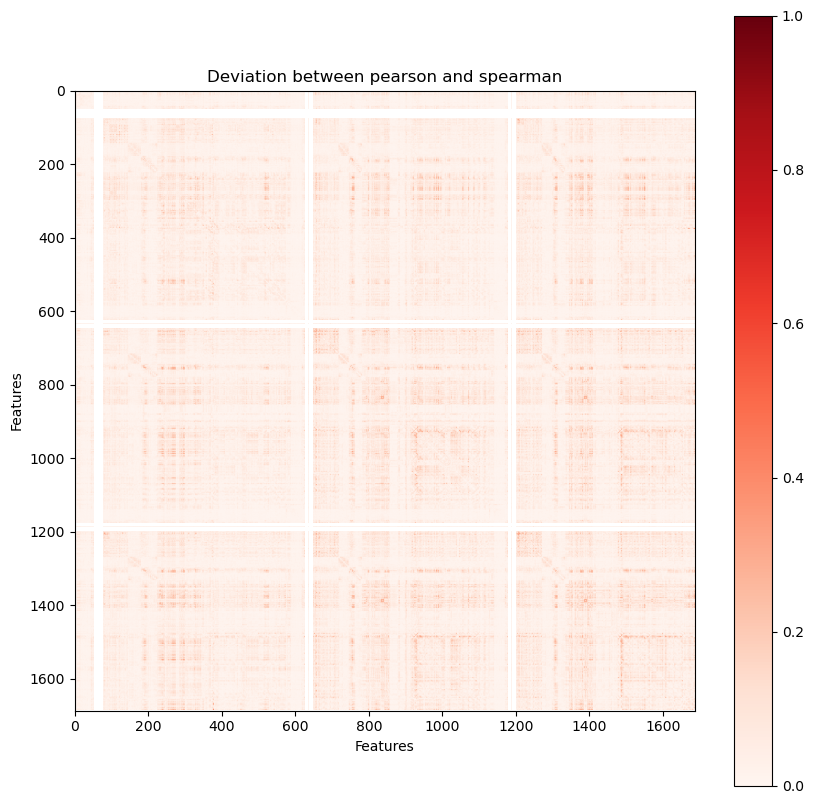

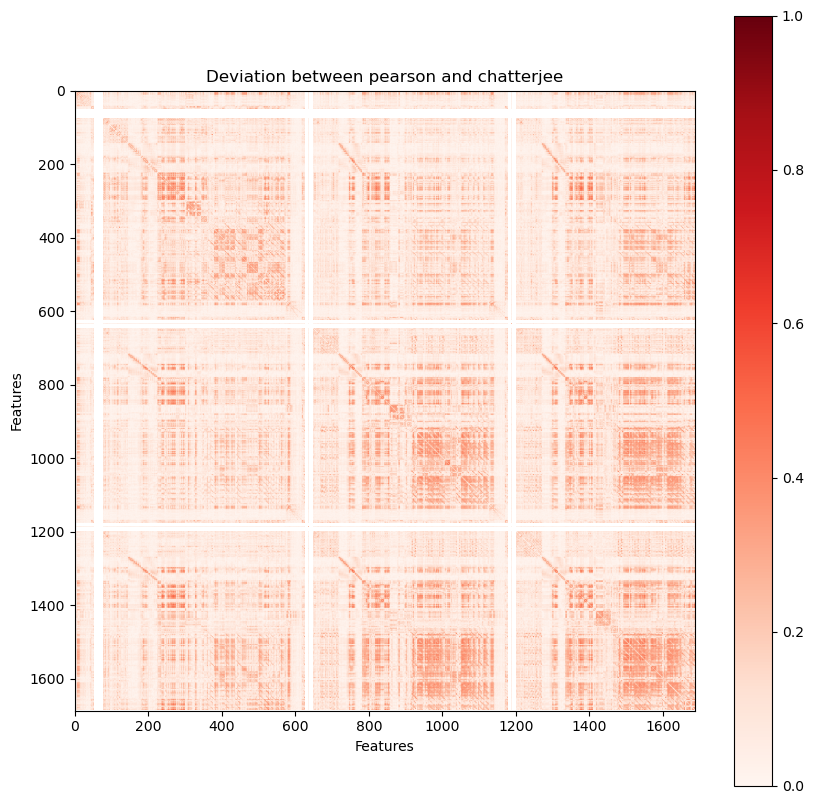

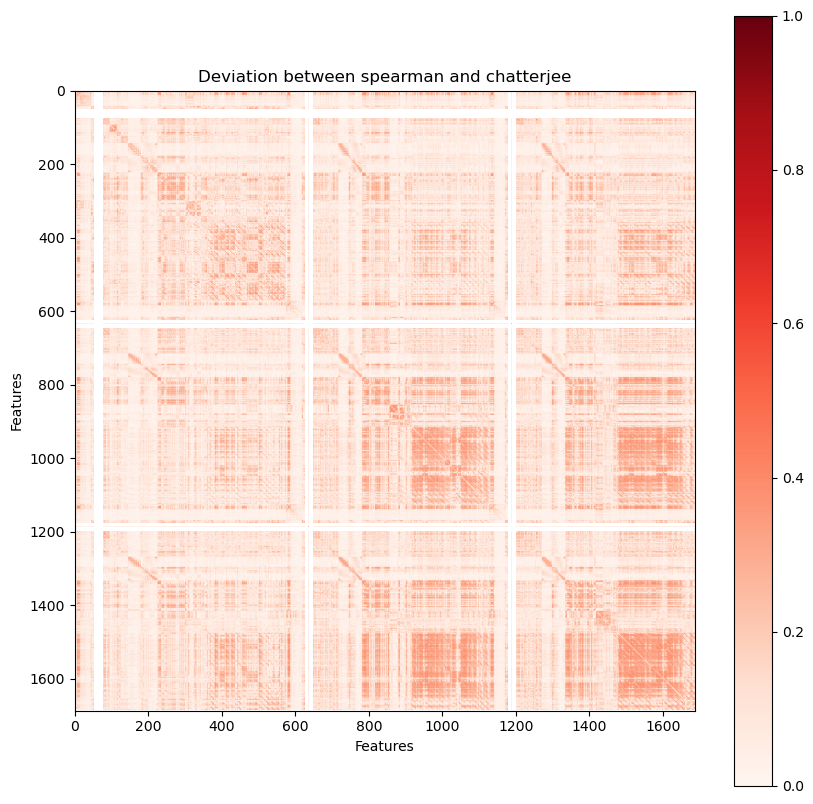

In [4]:
for i, method_1 in enumerate(adata.varm_keys()):
    for j, method_2 in enumerate(adata.varm_keys()):
        if j <= i:
            continue
        dev = np.abs(np.abs(adata.varm[method_1]) - np.abs(adata.varm[method_2]))
        # plot heatmap of deviations with matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(dev, vmin=0, vmax=1, cmap="Reds")
        plt.colorbar()
        plt.title(f"Deviation between {method_1} and {method_2}")
        plt.xlabel("Features")
        plt.ylabel("Features")
        plt.show()

We can observe that both Pearson and Spearman broadly agree, but that Chatterjee
differs in correlation for some feature pairs. To visualise why, we can
investigate individual examples.

In [5]:
def top_n_indices(df, N):
    flat_indices = np.argpartition(df.values.ravel(), -N)[-N:]
    unraveled_indices = np.array(np.unravel_index(flat_indices, df.shape)).T
    sorted_indices = unraveled_indices[
        np.argsort(df.values[tuple(unraveled_indices.T)][::-1])
    ]
    result = [(df.index[i], df.columns[j]) for i, j in sorted_indices]
    return result

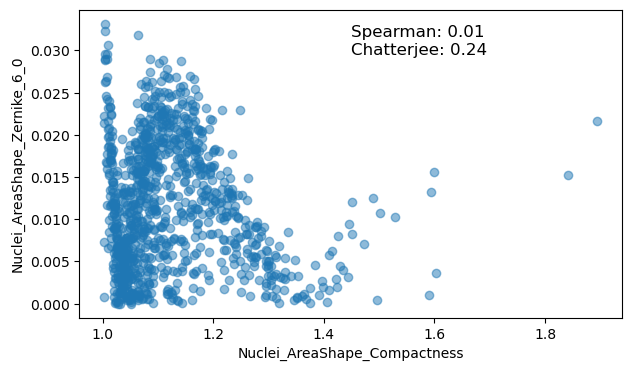

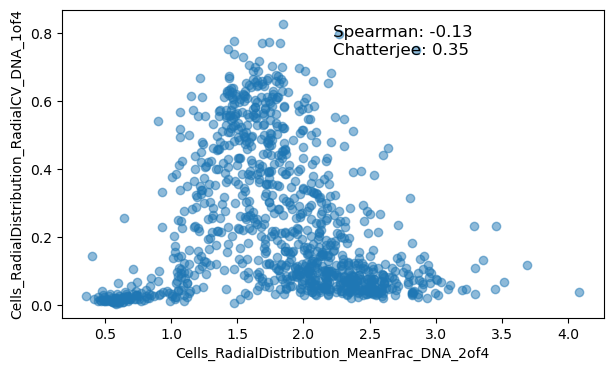

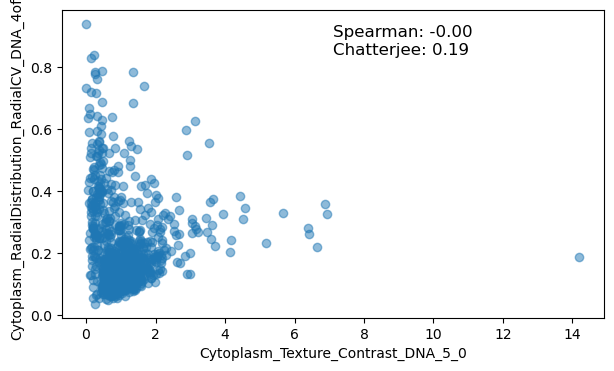

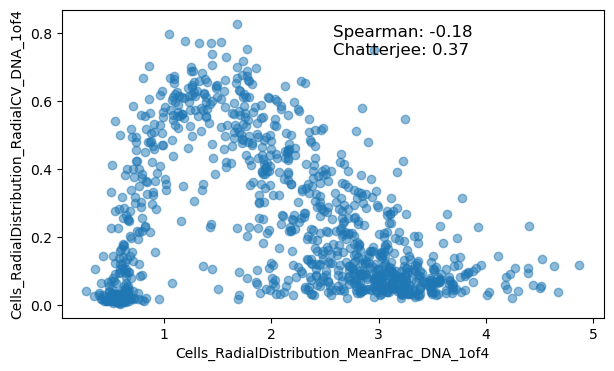

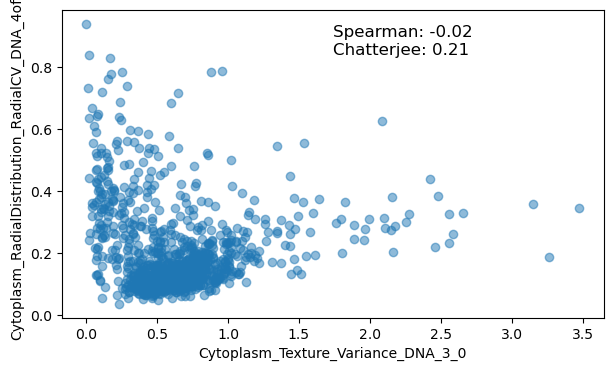

In [6]:
# get differences between chatterjee and spearman
# and filter out features with too many NaN or inf values
dev = adata.varm["chatterjee"] - np.abs(adata.varm["spearman"])
isna = np.bitwise_or(np.isinf(dev), np.isnan(dev))
mask = isna.sum(axis=0) <= adata.shape[0] * 0.1
dev = (adata.varm["chatterjee"] - np.abs(adata.varm["spearman"])).loc[mask, mask]
features = adata.var.index[mask]

# get top 5 feature combinations with the largest deviations
top_n_feature_combinations = top_n_indices(dev, 5)

# plot the top 5 feature combinations
for feature_1, feature_2 in top_n_feature_combinations:
    fig, ax = plt.subplots(figsize=(7, 4))
    df = adata[:, [feature_1, feature_2]].to_df()
    plt.scatter(df[feature_1], df[feature_2], alpha=0.5)
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    spearman = adata.varm["spearman"].loc[feature_1, feature_2]
    chatterjee = adata.varm["chatterjee"].loc[feature_1, feature_2]
    plt.text(
        0.5,
        0.95,
        f"Spearman: {spearman:.2f}\nChatterjee: {chatterjee:.2f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
    )
    plt.show()

We observe that Chatterjee detects some interesting associations, such as in the
case of a Zernike feature with nuclear compactness. Oftentimes these
relationships are underpinned by similarities in their computation, but seldom
are these relationships investigated in the realm of morphological profiling. We
hope that introducing the Chatterjee correlation to the field may aid
discovering such relationships in a data-driven way.